In [9]:
import os
import warnings
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from typing import List

# 환경 설정
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# API 키가 성공적으로 로드되었는지 확인합니다.
if api_key:
    print("API 키를 성공적으로 불러왔습니다.")
    # 보안을 위해 키의 앞 3글자만 출력하여 확인합니다. (Groq 키의 경우 'gsk'가 출력됩니다)
    print(f"API 키 시작 부분: {api_key[:3]}")
else:
    print("오류: .env 파일에서 OPENAI_API_KEY를 찾을 수 없거나 파일 로드에 실패했습니다.")
    print("노트북과 같은 위치에 .env 파일이 있는지, 파일 내 변수 이름이 정확한지 확인해주세요.")

warnings.filterwarnings("ignore")

API 키를 성공적으로 불러왔습니다.
API 키 시작 부분: gsk


In [10]:
# Agent의 상태를 LangGraph에 사전 정의된 MessagesState로 지정합니다.
class AgentState(MessagesState):
    pass

class CafeAgent:
    """
    카페 메뉴 질문에 답변하는 ReAct Agent 클래스
    """
    def __init__(self, db_path: str = "../db/cafe_db", embedding_model: str = "bge-m3:latest", llm_model: str = "llama3-70b-8192"):
        """
        Agent 초기화 시 필요한 구성 요소들을 설정합니다.
        """
        print("CafeAgent 초기화를 시작합니다...")
        
        # 설정(Configuration)
        self.db_path = db_path
        self.embedding_model_name = embedding_model
        self.llm_model_name = llm_model
        
        # 구성 요소 초기화
        self.embeddings_model = self._initialize_embeddings()
        self.cafe_db = self._load_vector_db()
        self.tools = [self._create_search_tool()]
        self.llm = self._initialize_llm()
        self.llm_with_tools = self.llm.bind_tools(tools=self.tools)
        
        # ReAct Agent (그래프) 생성
        self.agent = self._create_graph()
        
        print("CafeAgent가 성공적으로 생성되었습니다!")

    def _initialize_embeddings(self) -> OllamaEmbeddings:
        """Ollama 임베딩 모델을 초기화합니다."""
        return OllamaEmbeddings(model=self.embedding_model_name)

    def _load_vector_db(self) -> FAISS:
        """로컬 Vector DB(FAISS)를 로드합니다."""
        if not os.path.exists(self.db_path):
            raise FileNotFoundError(f"지정된 경로에 DB 파일이 없습니다: {self.db_path}")
        
        return FAISS.load_local(
            self.db_path, 
            self.embeddings_model, 
            allow_dangerous_deserialization=True
        )

    def _initialize_llm(self) -> ChatOpenAI:
        """Groq API를 사용하는 LLM을 초기화합니다."""
        groq_api_key = os.getenv("OPENAI_API_KEY")
        if not groq_api_key:
            raise ValueError(".env 파일에 OPENAI_API_KEY가 설정되지 않았거나 로드에 실패했습니다.")
        
        return ChatOpenAI(
            api_key=groq_api_key,
            base_url="https://api.groq.com/openai/v1",
            model_name=self.llm_model_name,
            temperature=0.7,
            streaming=True,
        )

    def _create_search_tool(self):
        """Vector DB를 검색하는 도구를 생성하고 반환합니다."""
        @tool
        def search_cafe_menu(query: str) -> str:
            """카페 메뉴 정보(이름, 가격, 재료, 설명 등)가 필요할 때 호출되는 도구입니다."""
            print(f"--- 도구 호출: search_cafe_menu(query='{query}') ---")
            docs = self.cafe_db.similarity_search(query, k=5)
            if not docs:
                return "관련 카페 메뉴 정보를 찾을 수 없습니다."
            return "\n\n---\n\n".join([f'<Document source="{doc.metadata.get("source", "N/A")}"/>\n{doc.page_content}\n</Document>' for doc in docs])
        
        return search_cafe_menu

    # === 이 부분이 수정되었습니다 ===
    def _get_system_prompt(self) -> str:
        """Agent의 역할과 지침을 정의하는 시스템 프롬프트를 반환합니다."""
        return """당신은 카페의 AI 어시스턴트입니다. 고객의 메뉴 관련 질문에 정확하고 친절하게 답변해주세요.
        
        다음 도구를 사용할 수 있습니다:
        - search_cafe_menu: 카페 메뉴에 대한 구체적인 정보(가격, 재료, 설명 등)가 필요할 때 사용하세요.
        
        고객의 질문을 이해하고, 필요한 경우 도구를 사용하여 정보를 찾은 후, 찾은 정보를 바탕으로 완전하고 친절한 답변을 생성하세요.
        
        **중요: 모든 최종 답변은 반드시 한국어로 작성해야 합니다. 고객의 질문이 한국어이면, 답변도 반드시 한국어로 해야 합니다.**
        """
    # ============================

    def _call_model_node(self, state: AgentState):
        """LLM을 호출하여 응답을 생성하는 노드 함수입니다."""
        print("--- Agent 노드: LLM 호출 ---")
        messages = [SystemMessage(content=self._get_system_prompt())] + state['messages']
        response = self.llm_with_tools.invoke(messages)
        print(f"LLM 응답 생성 완료. 도구 호출 여부: {bool(response.tool_calls)}")
        return {"messages": [response]}

    def _create_graph(self) -> StateGraph:
        """LangGraph를 사용하여 ReAct Agent의 작업 흐름(그래프)을 구성하고 컴파일합니다."""
        builder = StateGraph(AgentState)
        builder.add_node("agent", self._call_model_node)
        builder.add_node("tools", ToolNode(self.tools))
        builder.add_edge(START, "agent")
        builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")
        return builder.compile()

    def invoke(self, question: str) -> dict:
        """사용자의 질문을 받아 Agent를 실행하고 최종 결과를 반환합니다."""
        inputs = {"messages": [HumanMessage(content=question)]}
        return self.agent.invoke(inputs)

    def display_graph(self):
        """Agent의 구조를 이미지로 시각화하여 출력합니다."""
        try:
            img_data = self.agent.get_graph().draw_mermaid_png()
            display(Image(img_data))
        except Exception as e:
            print(f"그래프 시각화에 실패했습니다: {e}")

CafeAgent 초기화를 시작합니다...
CafeAgent가 성공적으로 생성되었습니다!


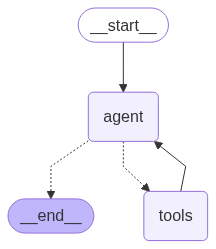

In [11]:
# CafeAgent 클래스의 인스턴스를 생성합니다.
# 로컬에 저장된 Vector DB 경로를 정확하게 지정해주세요.
# 예: db_path="./vector_db/my_cafe"
try:
    cafe_agent = CafeAgent(db_path="../db/cafe_db")

    # Agent의 작업 흐름 그래프를 시각화합니다.
    cafe_agent.display_graph()
except Exception as e:
    print(f"Agent 생성 또는 그래프 시각화 중 오류 발생: {e}")

In [12]:
def print_message_flow(result: dict):
    """Agent의 메시지 흐름을 분석하여 출력합니다."""
    print("\n--- 메시지 흐름 분석 ---")
    messages = result.get('messages', [])
    for i, message in enumerate(messages):
        print(f"{i+1}. 메시지 타입: {type(message).__name__}")
        
        # === 이 부분이 수정되었습니다 ===
        # 'tool_calls' 속성이 있는지 먼저 확인한 후, 내용이 있을 때만 접근합니다.
        if hasattr(message, 'tool_calls') and message.tool_calls:
            tool_call = message.tool_calls[0]
            print(f"   - 도구 호출: {tool_call['name']}(query='{tool_call['args']['query']}')")
        else:
            # HumanMessage 등 .content만 있는 메시지를 처리합니다.
            content_preview = message.content[:150].strip()
            if len(message.content) > 150:
                content_preview += "..."
            print(f"   - 내용: {content_preview}")
    # ============================

def run_single_test(agent: CafeAgent, question: str):
    """단일 질문에 대한 테스트를 실행하고 결과를 체계적으로 출력합니다."""
    if not agent:
        print("Agent가 초기화되지 않았습니다.")
        return
        
    print(f"\n{'='*70}")
    print(f"질문: {question}")
    print(f"{'='*70}")
    
    result = agent.invoke(question)
    
    # 수정된 함수를 호출합니다.
    print_message_flow(result)
    
    print(f"\n--- 최종 답변 ---")
    final_messages = result.get('messages', [])
    if final_messages:
        final_answer = final_messages[-1].content
        print(final_answer)
    else:
        print("최종 답변을 생성하지 못했습니다.")

In [13]:
# 첫 번째 테스트 질문
question_1 = "콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?"
run_single_test(cafe_agent, question_1)


질문: 콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

--- 메시지 흐름 분석 ---
1. 메시지 타입: HumanMessage
   - 내용: 콜드브루와 아이스 아메리카노의 차이점이 무엇인가요?
2. 메시지 타입: AIMessage
   - 내용: 😊

콜드브루와 아이스 아메리카노는 두 종류의 음료수입니다. 첫째, 콜드브루는 브루잉過程에서 추출된 에스프레소의맛을 냉장 처리하여 음용하는 음료수입니다. 이러한 방법으로 콜드브루는 원두의 맛과香氣를 잘 살릴 수 있습니다.

另一方面, 아이스 아메리카노는 에스프레소에 물...

--- 최종 답변 ---
😊

콜드브루와 아이스 아메리카노는 두 종류의 음료수입니다. 첫째, 콜드브루는 브루잉過程에서 추출된 에스프레소의맛을 냉장 처리하여 음용하는 음료수입니다. 이러한 방법으로 콜드브루는 원두의 맛과香氣를 잘 살릴 수 있습니다.

另一方面, 아이스 아메리카노는 에스프레소에 물을 추가하여 희석시킨 음료수입니다. 이를 冷却하여 음용할 수 있습니다. 아이스 아메리카노는 에스프레소의 맛을 약하게 하지만, 여전히 강한 커피의 맛을 느끼게 합니다.

따라서, 콜드브루와 아이스 아메리카노의 주요 차이점은 제조 방법과味입니다. 콜드브루는 에스프레소의 원래 맛을 잘 살리는 반면, 아이스 아메리카노는 에스프레소의 맛을 약하게 합니다.


In [14]:
# 두 번째 테스트 질문
question_2 = "디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요."
run_single_test(cafe_agent, question_2)


질문: 디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: True
--- 도구 호출: search_cafe_menu(query='티라미수') ---
--- Agent 노드: LLM 호출 ---
LLM 응답 생성 완료. 도구 호출 여부: False

--- 메시지 흐름 분석 ---
1. 메시지 타입: HumanMessage
   - 내용: 디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
2. 메시지 타입: AIMessage
   - 도구 호출: search_cafe_menu(query='티라미수')
3. 메시지 타입: ToolMessage
   - 내용: <Document source="N/A"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이...
4. 메시지 타입: AIMessage
   - 내용: 티라미수는 이탈리아 전통 디저트로, 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다. 가격은 ₩7,500입니다.

--- 최종 답변 ---
티라미수는 이탈리아 전통 디저트로, 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다. 가격은 ₩7,500입니다.
